# Phase response curve
A [phase response curve](https://en.wikipedia.org/wiki/Phase_response_curve) (PRC) measures the shift on an oscillations underlying phase caused by a stimulus as a function of when the stimulus was presented. In the context of our phase code solution to the M3A task, a network robust to the presentation of a stimulus should have PRCs that are constant across the phase of stimulus presentation. The measurement of PRCs can also be used to estimate the phase shift caused by task-specific stimuli.

## Imports

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import combinations_with_replacement

import jax
import jax.numpy as jnp
from jax import random

import scipy.signal
import scipy.stats

from ctrnn_jax.model import CTRNNCell
from ctrnn_jax.training import ModelParameters, create_train_state
from ctrnn_jax.pca import compute_pca

from emergence_phase_codes.model import initialize_ctrnn
from emergence_phase_codes.task import ModuloNArithmetic

from emergence_phase_codes.animations.output import OutputAnimator
from emergence_phase_codes.animations.pca import PCATrajectoryAnimator

In [2]:
key = random.PRNGKey(69)

## Configure parameters

In [3]:
# Modulo3Arithmetic task parameters
BATCH_SIZE_M3A = 16

MOD = 3
CONGRUENT_NUMBER = 0
TIME_LENGTH = 50
NUM_TRIALS = 2500

TRIALS_PER_POS = 100
TRIALS_PER_NEG = 50

PULSE_CONFIG = {
    "num_pulses": 3,
    "pulse_window": 40,
    "pulse_buffer": 5,
    "pulse_gap": 5,
    "pulse_amplitude": 5,
}

INIT_ARRAY_M3A = jnp.ones([BATCH_SIZE_M3A, TIME_LENGTH, MOD])

In [4]:
# Configure model parameters
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 1
ALPHA = 1.0
NOISE_SCALAR = 0.00

## Initialize MNA task

In [5]:
# Initialize task
key, task_key = random.split(key, num=2)
task = ModuloNArithmetic(
    task_key, 
    MOD,
    congruent_number=CONGRUENT_NUMBER,
    time_length=TIME_LENGTH,
    num_trials=NUM_TRIALS,
    pulse_config=PULSE_CONFIG,
)
task.return_number_of_sequences()

27

In [6]:
# Initialize tensorflow dataset
tf_dataset_train = task.generate_tf_dataset(BATCH_SIZE_M3A)
len(task.dataset)

2500

## Load CT-RNN

In [7]:
# Initialize model
ctrnn = initialize_ctrnn(
    hidden_features=HIDDEN_FEATURES,
    output_features=OUTPUT_FEATURES,
    alpha=ALPHA,
    noise_const=NOISE_SCALAR,
)

In [8]:
# Initialize train state
key, train_state_key = random.split(key, num=2)
train_state = create_train_state(
    train_state_key, 
    ctrnn, 
     1E-4, 
    INIT_ARRAY_M3A,
)

In [9]:
# Load parameters
params = ModelParameters(train_state)
params.deserialize("../data/phase_code_solution_m3a_task.bin")

## Compute PCA and null rates

In [10]:
# Compute PCA
key, pca_key = random.split(key, num=2)
model_behavior, pca = compute_pca(
    pca_key,
    train_state,
    params.params,
    tf_dataset_train,
    3,
)

In [11]:
# Compute null rates
key, test_key = random.split(key, num=2)
output_null, rates_null = train_state.apply_fn(
    params.params, 
    jnp.zeros((1, 2 * TIME_LENGTH, MOD)), 
    rngs={"noise_stream": test_key}
)
rates_null = pca.transform(rates_null[0,:,:])

In [12]:
# Figure arguments
pc1_dict = {0: rates_null[:, 0]}
pc2_dict = {0: rates_null[:, 1]}

null_behavior = {'rates_pc': rates_null[None, :, :]}
trajectory_indices = [0]
trajectory_colors = {0: ['tab:grey'] * (2 * TIME_LENGTH)}

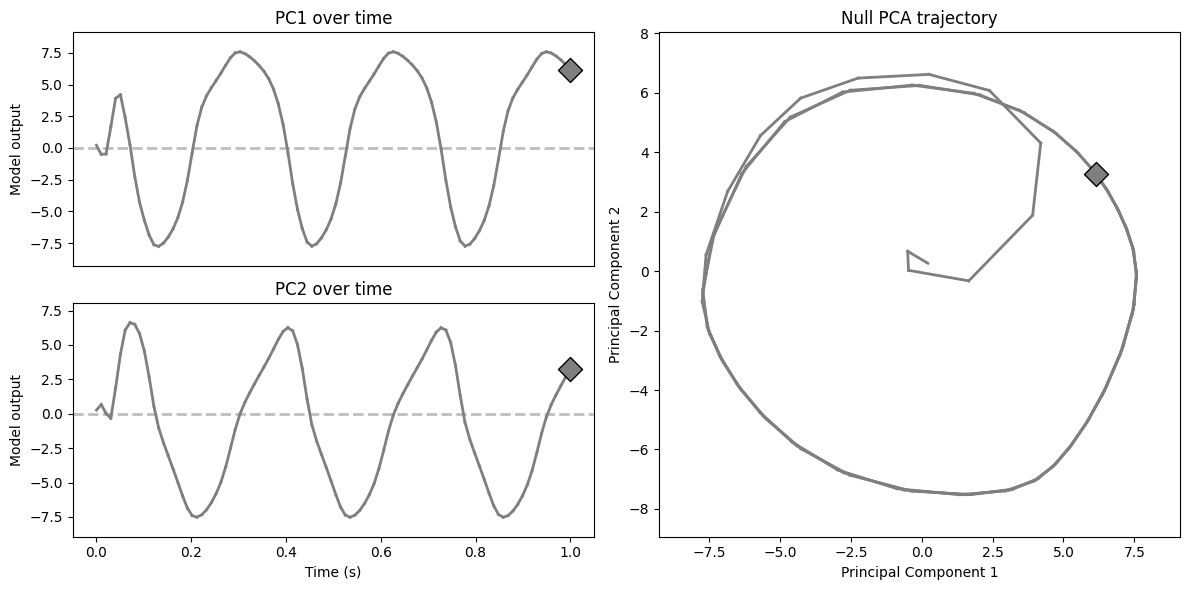

In [13]:
# Create the Figure
fig_anim = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 2)

# Panel 1
ax_1 = fig_anim.add_subplot(gs[0, 0])
animator_1 = OutputAnimator(
    ax_1, pc1_dict, trajectory_colors,
    title='PC1 over time',
)
ax_1.set_xticks([])
ax_1.set_xlabel('')
animator_1.figure()

# Panel 2
ax_2 = fig_anim.add_subplot(gs[1, 0,])
animator_2 = OutputAnimator(
    ax_2, pc2_dict, trajectory_colors,
    title='PC2 over time',
)
animator_2.figure()

# Panel 1
ax_3 = fig_anim.add_subplot(gs[:, 1])
animator_3 = PCATrajectoryAnimator(
    ax_3, null_behavior, 1, 2, 
    trajectory_indices, trajectory_colors, 
    'Null PCA trajectory',
)
animator_3.figure()

plt.tight_layout()
plt.show()

## Visualize pulses

In [14]:
pulse_loc = 32

In [15]:
# Compute 0 pulse rates
input_0 = jnp.zeros((1, 2 * TIME_LENGTH, MOD))
input_0 = input_0.at[0, pulse_loc, 0].add(PULSE_CONFIG['pulse_amplitude'])
input_0 = input_0.at[0, pulse_loc+1, 0].add(PULSE_CONFIG['pulse_amplitude'])

output_0, rates_0 = train_state.apply_fn(
    params.params, 
    input_0, 
    rngs={"noise_stream": test_key}
)
rates_0 = pca.transform(rates_0[0,:,:])

In [16]:
# Compute 1 pulse rates
input_1 = jnp.zeros((1, 2 * TIME_LENGTH, MOD))
input_1 = input_1.at[0, pulse_loc, 1].add(PULSE_CONFIG['pulse_amplitude'])
input_1 = input_1.at[0, pulse_loc+1, 1].add(PULSE_CONFIG['pulse_amplitude'])

output_1, rates_1 = train_state.apply_fn(
    params.params, 
    input_1, 
    rngs={"noise_stream": test_key}
)
rates_1 = pca.transform(rates_1[0,:,:])

In [17]:
# Compute 0 pulse rates
input_2 = jnp.zeros((1, 2 * TIME_LENGTH, MOD))
input_2 = input_2.at[0, pulse_loc, 2].add(PULSE_CONFIG['pulse_amplitude'])
input_2 = input_2.at[0, pulse_loc+1, 2].add(PULSE_CONFIG['pulse_amplitude'])

output_2, rates_2 = train_state.apply_fn(
    params.params, 
    input_2, 
    rngs={"noise_stream": test_key}
)
rates_2 = pca.transform(rates_2[0,:,:])

In [18]:
# Figure arguments
pulse_behavior = {
    'rates_pc': jnp.stack((rates_null, rates_0, rates_1, rates_2,), axis=0),
}
trajectory_indices = [0, 1, 2, 3]
trajectory_colors = {
    0: ['tab:grey']*(TIME_LENGTH*2),
    1: ['tab:green']*(TIME_LENGTH*2),
    2: ['tab:red']*(TIME_LENGTH*2),
    3: ['tab:purple']*(TIME_LENGTH*2),
}

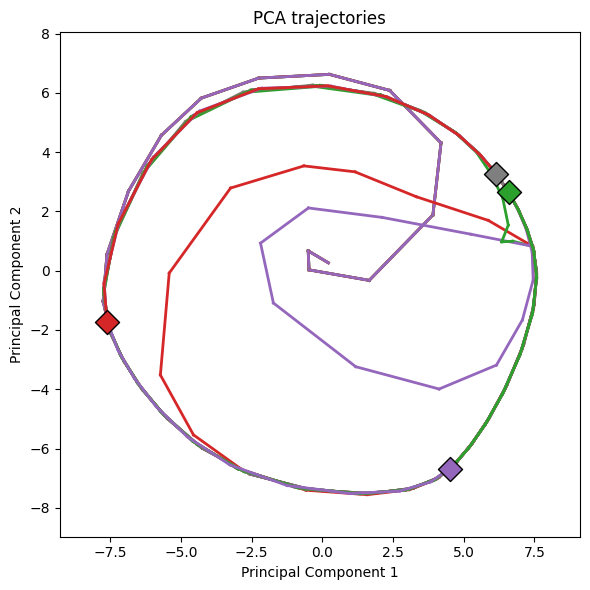

In [19]:
# Create the Figure
fig_anim = plt.figure(figsize=(6, 6))
gs = GridSpec(1, 1)

# Panel 1
ax_1 = fig_anim.add_subplot(gs[0, 0])
animator_1 = PCATrajectoryAnimator(
    ax_1, pulse_behavior, 1, 2, 
    trajectory_indices, trajectory_colors, 
    'PCA trajectories',
)
animator_1.figure()

plt.tight_layout()
plt.show()

## Measure phase

In [20]:
def estimate_period_by_peaks(signal: jnp.ndarray, distance=5) -> float:
    """
    Estimate oscillation period by averaging time between successive peaks.

    Args:
        signal (jnp.ndarray): 1D oscillatory signal.
        distance (int): Minimum number of time steps between peaks (for filtering close peaks).

    Returns:
        float: Average period (in time steps) between detected peaks.
    """
    # Convert to NumPy since scipy functions are not JAX-compatible
    peaks, _ = scipy.signal.find_peaks(jnp.asarray(signal), distance=distance)
    if len(peaks) < 2:
        return -1  # Not enough peaks to compute period

    peak_intervals = jnp.diff(peaks)
    return scipy.stats.mode(jnp.asarray(peak_intervals)).mode.item()

In [21]:
period = estimate_period_by_peaks(rates_null[:,0])
period

32

## Measure and plot phase responce curves (PRCs)

In [22]:
def compute_prc_tensor(key, train_state, params, pca, mod, period, pulse_amplitude):
    """
    Compute a PRC tensor for each input type and pulse time relative to oscillation phase.

    Args:
        key (jax.random.PRNGKey): Random key.
        train_state: Flax training state containing apply_fn.
        params: Trained model parameters.
        pca: Trained PCA object.
        mod (int): Number of input types (e.g., 3).
        period (int): Oscillation period in time steps.
        pulse_amplitude (float): Amplitude of the input pulses.

    Returns:
        pulse_phase: shape (period), containing phases of presented pulses
        prc_tensor: shape (mod, period, period), containing phase shifts in radians.
    """
    pulse_phase = jnp.zeros(period)
    prc_tensor = jnp.zeros((mod, period, period))

    # Run null trajectory
    key, subkey = random.split(key)
    null_input = jnp.zeros((1, 4 * period, mod))
    _, null_rates = train_state.apply_fn(params.params, null_input, rngs={"noise_stream": subkey})
    null_rates_pc = pca.transform(null_rates[0])
    null_angles = jnp.arctan2(
        null_rates_pc[3 * period : 4 * period, 1], 
        null_rates_pc[3 * period : 4 * period, 0]
    )

    for i in range(mod):
        for t_pulse in range(period):
            key, subkey = random.split(key)

            # Calculate the pulse phase
            pulse_idx = period + t_pulse
            pulse_angle = jnp.arctan2(null_rates_pc[pulse_idx, 1], null_rates_pc[pulse_idx, 0])
            pulse_phase = pulse_phase.at[t_pulse].set(pulse_angle)

            # Create perturbed input with pulse at global time (period + t_pulse)
            pert_input = jnp.zeros((1, 4 * period, mod))
            pert_input = pert_input.at[0, pulse_idx, i].add(pulse_amplitude)
            pert_input = pert_input.at[0, pulse_idx + 1, i].add(pulse_amplitude)

            # Simulate perturbed trajectory
            _, pert_rates = train_state.apply_fn(params.params, pert_input, rngs={"noise_stream": subkey})
            pert_rates_pc = pca.transform(pert_rates[0])
            pert_angles = jnp.arctan2(
                pert_rates_pc[3 * period : 4 * period, 1], 
                pert_rates_pc[3 * period : 4 * period, 0]
            )

            # Phase shift = angle difference (wrapped to [-π, π])
            phase_shift = (pert_angles - null_angles + jnp.pi) % (2 * jnp.pi) - jnp.pi
            prc_tensor = prc_tensor.at[i, t_pulse, :].set(phase_shift)

    return pulse_phase, prc_tensor

In [23]:
key, prc_key = random.split(key, num=2)
pulse_phase, prc_tensor = compute_prc_tensor(
    prc_key,
    train_state,
    params,
    pca,
    MOD,
    period,
    PULSE_CONFIG['pulse_amplitude'],
)
prc_tensor.shape

(3, 32, 32)

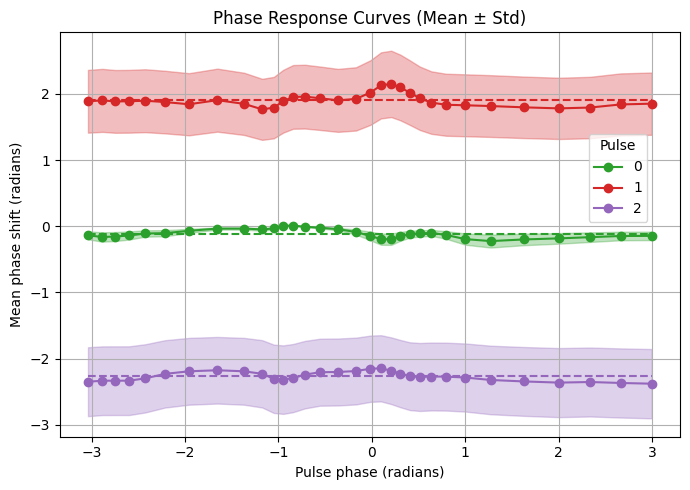

In [24]:
# Compute mean and std
mean_prc = prc_tensor.mean(axis=2)
std_prc = prc_tensor.std(axis=2)

# Sort by pulse_phase
sort_idx = jnp.argsort(pulse_phase)
pulse_phase_sorted = pulse_phase[sort_idx]
mean_prc_sorted = mean_prc[:, sort_idx]
std_prc_sorted = std_prc[:, sort_idx]

# Plotting
colors = ['tab:green', 'tab:red', 'tab:purple']
labels = ['0', '1', '2']

plt.figure(figsize=(7, 5))
for i in range(MOD):
    data = prc_tensor[i]
    mean = mean_prc_sorted[i]
    std = std_prc_sorted[i]
    color = colors[i]
    
    # Plot mean line
    plt.plot(pulse_phase_sorted, mean, 'o-', label=labels[i], color=color)
    
    # Plot shaded std deviation
    plt.fill_between(
        pulse_phase_sorted,
        mean - std,
        mean + std,
        color=color,
        alpha=0.3,
    )

    # Compute and plot constant fit (mean across phases)
    constant_fit = jnp.mean(data)
    plt.hlines(
        constant_fit,
        xmin=pulse_phase_sorted[0],
        xmax=pulse_phase_sorted[-1],
        colors=color,
        linestyles='dashed',
        linewidth=1.5,
    )

plt.xlabel("Pulse phase (radians)")
plt.ylabel("Mean phase shift (radians)")
plt.title("Phase Response Curves (Mean ± Std)")
plt.legend(
    title="Pulse", 
    loc="center",
    bbox_to_anchor=(0.9, 0.64),
)
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
jnp.save('../data/prc_tensor.npy', prc_tensor)
jnp.save('../data/pulse_phase.npy', pulse_phase)

## Manipulating mean phase shifts

In [26]:
mean_phase_shifts = prc_tensor.mean(axis=(1,2))
mean_phase_shifts

Array([-0.11230101,  1.9016894 , -2.2716827 ], dtype=float32)

In [27]:
# Generate all multiset combinations (order doesn't matter, repetition allowed)
combinations = list(combinations_with_replacement([0, 1, 2], 3))

# Compute phase sums
phase_sums = []
labels = []
for combo in combinations:
    total_phase = sum(mean_phase_shifts[i] for i in combo) % (2 * jnp.pi)
    phase_sums.append(total_phase)
    labels.append("".join(str(i) for i in combo))

# Sort for clean plotting
phase_sums = jnp.array(phase_sums)
sorted_idx = jnp.argsort(phase_sums)
phase_sums_sorted = phase_sums[sorted_idx]
labels_sorted = [labels[i] for i in sorted_idx]

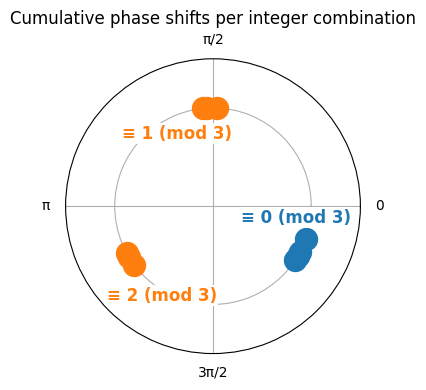

In [28]:
# Create circular plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))
theta = phase_sums_sorted
radii = jnp.ones_like(theta)

# Plot points
ax.scatter(theta[:6], radii[:6], s=250, c='tab:orange', zorder=2)
ax.scatter(theta[6:], radii[6:], s=250, c='tab:blue', zorder=2)

# Custom cluster labels (anchor theta, radius)
label_data = [
    (theta[0]+.5, 0.825, r"≡ 1 (mod 3)", 'tab:orange'),
    (theta[4]+.5, 1.05, r"≡ 2 (mod 3)", 'tab:orange'),
    (theta[-1]+.2, 0.85, r"≡ 0 (mod 3)", 'tab:blue'),
]

for angle, radius, label, color in label_data:
    ax.text(
        angle,
        radius,
        label,
        ha='center',
        va='center',
        fontsize=12,
        color=color,
        fontweight='bold',
        zorder=3,
        bbox=dict(facecolor='white', edgecolor='none', pad=1),
    )

ax.set_rmax(1.5)
ax.set_rticks([1,])
ax.set_yticklabels([])

ax.set_thetagrids([0, 90, 180, 270], ['0', 'π/2', 'π', '3π/2'])

ax.set_title("Cumulative phase shifts per integer combination")
plt.tight_layout()
plt.show()